In [1]:
# 1. Get essential libraries
from vnstock import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Observations:  1630


<Axes: xlabel='Time'>

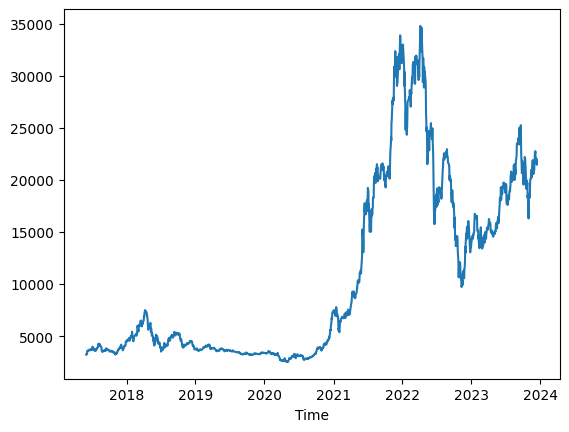

In [2]:
#2. Fetch data and visualize
# VND
VND = stock_historical_data(symbol = "VND", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VND['Close']))
VND
VND["Close"].plot()

In [3]:
# Preprocessing
df = pd.DataFrame(VND['Close'])
df = df.dropna() 
df = df.reset_index(drop=True)
df

,Close
0,3230
1,3280
2,3280
3,3320
4,3590
...,...
1625,21950
1626,22050
1627,21600
1628,21450


In [4]:
# Check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Close'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
#Not stationary

ADF stat: -1.199031
p-value: 0.674012


In [5]:
adf2 = adfuller(df['Close'].diff().dropna(), regression ='c', maxlag=30)
print("ADF stat: %f" % adf2[0])
print("p-value: %f" % adf2[1])
#Stationary

ADF stat: -5.780095
p-value: 0.000001


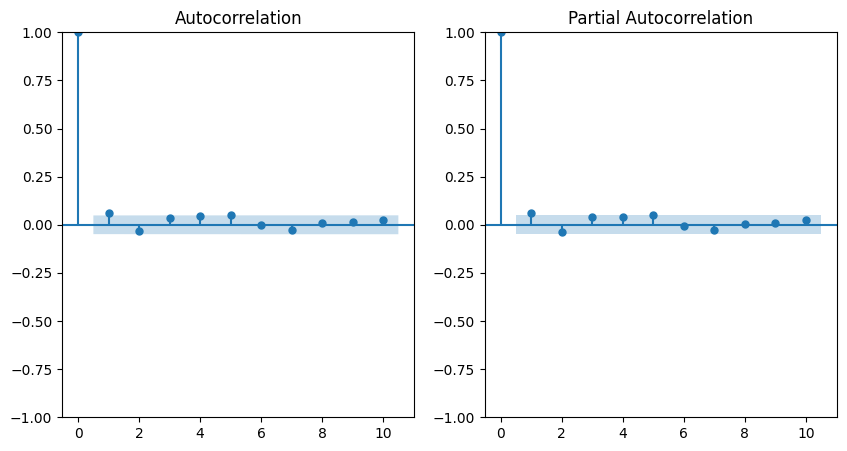

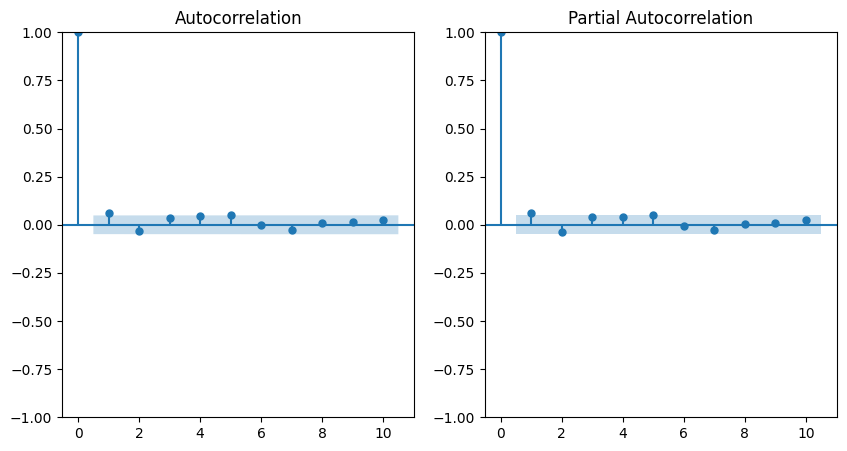

In [6]:
# Difference the data and plot the acf
fig, ax = plt.subplots(1,2,figsize=(10,5))
#ACF
sm.graphics.tsa.plot_acf(np.diff(df['Close']),lags=10, ax=ax[0])
# PACF
sm.graphics.tsa.plot_pacf(np.diff(df['Close']),lags=10, ax=ax[1])

In [7]:
#3. Slit the data into train : 
# Test with ratio 7:3
train_size73 = int(0.7 * len(df))
test_size73 = int(0.3 * len(df))

train_data73 = df[:train_size73]
test_data73 = df[train_size73:]

In [8]:
# 4. Training process
# 7 : 3 RATIO
x_train73 = np.array(train_data73.index).reshape(-1, 1)
y_train73 = np.array(train_data73['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

model73 = auto_arima(y_train73, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model_fit73 = model73.fit(y_train73)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=16944.467, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=16690.143, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=16203.336, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.683 seconds


In [10]:
# 5. Testing process
# 7:3 RATIO
x_test73 = np.array(test_data73.index).reshape(-1, 1)
y_test73 = np.array(test_data73['Close'])
y_pred73 = model73.predict(n_periods=len(y_test73))

In [11]:
# 7:3 RATIO
last_index73 =  df.index[-1]
last_data73 =pd.RangeIndex(start=last_index73, stop=last_index73 + 60, step=1)

#create an array of 60 integers starting from last index
x_next_60_days73 = np.array(range(last_index73 + 1, last_index73 + 61)).reshape(-1, 1)

#predict the price for the next 60 days.
y_next_60_days73 = model73.predict(len(x_next_60_days73))

#print the prices for the next 60 days.
print('Predicted prices for the next 60 days: ')
print(y_next_60_days73)

Predicted prices for the next 60 days: 
[32721.89150861 32843.78301722 32965.67452583 33087.56603443
 33209.45754304 33331.34905165 33453.24056026 33575.13206887
 33697.02357748 33818.91508609 33940.8065947  34062.6981033
 34184.58961191 34306.48112052 34428.37262913 34550.26413774
 34672.15564635 34794.04715496 34915.93866357 35037.83017217
 35159.72168078 35281.61318939 35403.504698   35525.39620661
 35647.28771522 35769.17922383 35891.07073244 36012.96224104
 36134.85374965 36256.74525826 36378.63676687 36500.52827548
 36622.41978409 36744.3112927  36866.20280131 36988.09430991
 37109.98581852 37231.87732713 37353.76883574 37475.66034435
 37597.55185296 37719.44336157 37841.33487018 37963.22637878
 38085.11788739 38207.009396   38328.90090461 38450.79241322
 38572.68392183 38694.57543044 38816.46693905 38938.35844765
 39060.24995626 39182.14146487 39304.03297348 39425.92448209
 39547.8159907  39669.70749931 39791.59900792 39913.49051652]


In [12]:
# 7:3 RATIO
#RMSE
test_rmse = np.sqrt(np.mean((y_pred73 - y_test73)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test73 - y_pred73) / y_test73)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred73 - y_test73))
print('Testing MAE:', test_mae)

def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("Testing MSLR: ", MSLE(y_pred73, y_test73))

Testing RMSE: 47067.52161981123
Testing MAPE: 244.20212197881713
Testing MAE: 42438.52639233627
Testing MSLR:  1.5264467262071875


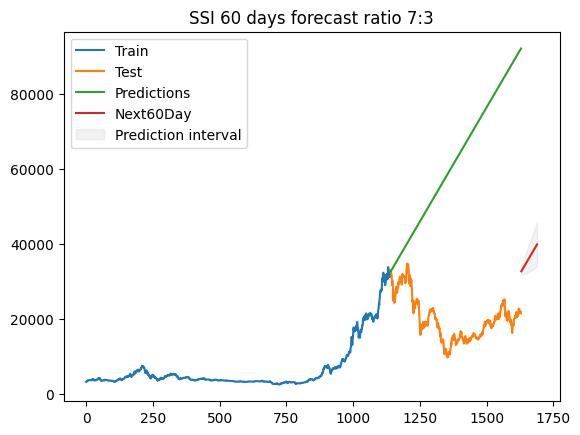

In [13]:
# 7:3 RATIO
# Forecast
n_periods = 60
fc, confint = model_fit73.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df['Close']), len(df['Close'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train_data73.index, train_data73['Close'])
plt.plot(test_data73.index, test_data73['Close'])
plt.plot(test_data73.index, y_pred73)

plt.plot(fc_series)
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.05)
plt.legend(['Train', 'Test', 'Predictions','Next60Day', 'Prediction interval'])

plt.title("SSI 60 days forecast ratio 7:3")
plt.show()

In [ ]:
ARIMA(2,2,2)(0,0,0)[0]   x          : AIC=inf, Time=0.52 sec
 ARIMA(0,2,0)(0,0,0)[0]  x           : AIC=15050.755, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]  x           : AIC=14823.523, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]  x           : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]  x           : AIC=14715.280, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=14628.562, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=14571.990, Time=0.07 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=14553.199, Time=0.05 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=14555.185, Time=0.11 sec

In [14]:
#Forecast with ARIMA(2, 1, 2)
model73 = sm.tsa.arima.ARIMA(
    train_data73,
    order = (1,1,2)
)
model_fit73 = model73.fit()
model_fit73.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1141
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -8112.422
Date:                Sat, 30 Dec 2023   AIC                          16232.844
Time:                        22:20:25   BIC                          16252.999
Sample:                             0   HQIC                         16240.455
                               - 1141                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0389      0.285      0.137      0.891      -0.519       0.597
ma.L1          0.0182      0.286      0.064      0.949      -0.543       0.579
ma.L2         -0.0412      0.022     -1.902      0.057      -0.084       0.001
sigma2      8.882e+04   1321.138     67.233      0.000    8.62e+04    9.14e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             10702.97
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              11.37   Skew:                             1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# 5. Testing process
# 8:2 RATIO
x_test73 = np.array(test_data73.index).reshape(-1, 1)
y_test73 = np.array(test_data73['Close'])
y_pred73 = model_fit73.predict(start = train_size73, end = train_size73+test_size73)
y_pred73

1141    32520.108000
1142    32532.928683
1143    32533.427865
1144    32533.447301
1145    32533.448058
            ...     
1626    32533.448089
1627    32533.448089
1628    32533.448089
1629    32533.448089
1630    32533.448089
Name: predicted_mean, Length: 490, dtype: float64

In [16]:
# 6. 60 days prediction
# 8:2 RATIO
last_index73 =  df.index[-1]
last_data73 =pd.RangeIndex(start=last_index73, stop=last_index73 + 60, step=1)

#create an array of 60 integers starting from last index
x_next_60_days73 = np.array(range(last_index73 + 1, last_index73 + 61)).reshape(-1, 1)

#predict the price for the next 60 days.
y_next_60_days73 = model_fit73.predict(start = len(df)+1, end = len(df)+60)
print(len(x_next_60_days73))
#print the prices for the next 60 days.
print('Predicted prices for the next 60 days: ')
print(y_next_60_days73)

60
Predicted prices for the next 60 days: 
1631    32533.448089
1632    32533.448089
1633    32533.448089
1634    32533.448089
1635    32533.448089
1636    32533.448089
1637    32533.448089
1638    32533.448089
1639    32533.448089
1640    32533.448089
1641    32533.448089
1642    32533.448089
1643    32533.448089
1644    32533.448089
1645    32533.448089
1646    32533.448089
1647    32533.448089
1648    32533.448089
1649    32533.448089
1650    32533.448089
1651    32533.448089
1652    32533.448089
1653    32533.448089
1654    32533.448089
1655    32533.448089
1656    32533.448089
1657    32533.448089
1658    32533.448089
1659    32533.448089
1660    32533.448089
1661    32533.448089
1662    32533.448089
1663    32533.448089
1664    32533.448089
1665    32533.448089
1666    32533.448089
1667    32533.448089
1668    32533.448089
1669    32533.448089
1670    32533.448089
1671    32533.448089
1672    32533.448089
1673    32533.448089
1674    32533.448089
1675    32533.448089
1676    3253

In [19]:
# 6:4 RATIO
#RMSE
test_rmse = np.sqrt(np.mean((y_pred73[:len(y_test73)] - y_test73)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test73 - y_pred73[:len(y_test73)]) / y_test73)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred73[:len(y_test73)] - y_test73))
print('Testing MAE:', test_mae)

def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("Testing MSLR: ", MSLE(y_pred73[:len(y_test73)], y_test73))

Testing RMSE: 13723.771948695885
Testing MAPE: 75.59850905417149
Testing MAE: 12557.938633909962
Testing MSLR:  0.3516580691595856


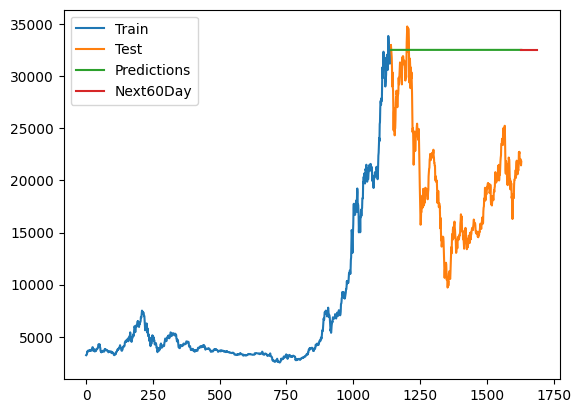

In [51]:
#Show plot ratio 6:4
plt.plot(train_data73.index, train_data73['Close'])
plt.plot(test_data73.index, test_data73['Close'])
plt.plot(test_data73.index, y_pred73[:len(y_test73)])

plt.plot(last_data73,y_next_60_days73)
plt.legend(['Train', 'Test', 'Predictions','Next60Day'])
plt.show()
# Better